In [1]:
import cv2
import numpy as np

SIFT

In [ ]:
img1_gray=cv2.imread("C:\ProgramCode\Projects\BADOU_AI\7.sift & opencv算法\sift\iphone1.png")
img2_gray=cv2.imread("C:\ProgramCode\Projects\BADOU_AI\7.sift & opencv算法\sift\iphone2.png")

sift=cv2.SIFT()

kp1,des1=sift.detectAndCompute(img1_gray,None)
kp2,des2=sift.detectAndCompute(img2_gray,None)

bf=cv2.BFMatcher(cv2.NORM_L2)
matches=bf.knnMatch(des1,des2,k=2)

goodMatch=[]
for m,n in matches:
    if m.distance< 0.5*n.distance:
        goodMatch.append(m)


RANSAC

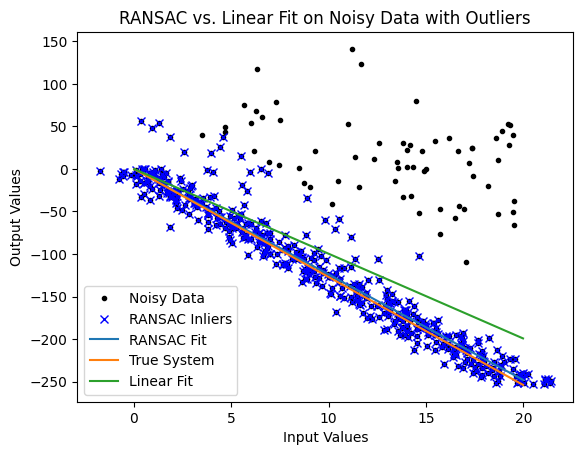

In [5]:
import numpy as np
import scipy as sp
import scipy.linalg as sl
import matplotlib.pyplot as plt


def ransac(data, model, min_samples, max_iterations, error_threshold, inlier_threshold, debug=False, return_all=False):
    """
    执行随机抽样一致性算法（RANSAC）以拟合模型。

    参数:
        data (np.ndarray): 样本点数据。
        model (object): 用于拟合数据的模型对象。
        min_samples (int): 生成模型所需的最少样本点数量。
        max_iterations (int): 最大迭代次数。
        error_threshold (float): 作为判断点满足模型的误差阈值。
        inlier_threshold (int): 拟合较好时需要的样本点最少数量（当做阈值看待）。
        debug (bool, 可选): 是否输出调试信息。默认 False。
        return_all (bool, 可选): 是否返回所有相关信息（包括局内点索引）。默认 False。

    返回:
        最佳拟合模型结果或包含更多信息的字典（取决于 return_all 的值）。
    """
    best_fit = None
    lowest_error = np.inf
    best_inlier_idxs = None
    iterations = 0

    while iterations < max_iterations:
        potential_inlier_idxs, test_idxs = random_partition(min_samples, data.shape[0])
        potential_inliers = data[potential_inlier_idxs,:]
        test_points = data[test_idxs]

        potential_model = model.fit(potential_inliers)
        test_errors = model.get_error(test_points, potential_model)

        also_inlier_idxs = test_idxs[test_errors < error_threshold]
        also_inliers = data[also_inlier_idxs, :]

        if debug:
            print('Test errors - min:', test_errors.min())
            print('Test errors - max:', test_errors.max())
            print('Numpy mean of test errors:', np.mean(test_errors))
            print(f'Iteration {iterations}: len(also_inliers) = {len(also_inliers)}')

        if len(also_inliers) > inlier_threshold:
            better_data = np.concatenate((potential_inliers, also_inliers))
            better_model = model.fit(better_data)
            better_errors = model.get_error(better_data, better_model)
            mean_error = np.mean(better_errors)

            if mean_error < lowest_error:
                best_fit = better_model
                lowest_error = mean_error
                best_inlier_idxs = np.concatenate((potential_inlier_idxs, also_inlier_idxs))

        iterations += 1

    if best_fit is None:
        raise ValueError("Didn't meet fit acceptance criteria")

    if return_all:
        return best_fit, {'inliers': best_inlier_idxs}
    else:
        return best_fit


def random_partition(min_sample_count, data_size):
    """
    将数据随机划分为两部分。

    参数:
        min_sample_count (int): 一部分数据的样本点数量。
        data_size (int): 原始数据的总样本点数量。

    返回:
        两部分数据的索引数组。
    """
    all_idxs = np.arange(data_size)
    np.random.shuffle(all_idxs)
    selected_idxs = all_idxs[:min_sample_count]
    remaining_idxs = all_idxs[min_sample_count:]
    return selected_idxs, remaining_idxs


class LinearLeastSquareModel:
    """
    最小二乘求线性解的模型类，用于 RANSAC 的输入模型。

    参数:
        input_cols (list): 输入数据的列索引列表。
        output_cols (list): 输出数据的列索引列表。
        debug (bool, 可选): 是否输出调试信息。默认 False。
    """
    def __init__(self, input_cols, output_cols, debug=False):
        self.input_cols = input_cols
        self.output_cols = output_cols
        self.debug = debug

    def fit(self, data):
        """
        使用最小二乘法拟合数据生成模型参数。

        参数:
            data (np.ndarray): 输入数据。

        返回:
            模型参数（最小二乘解向量）。
        """
        A = np.vstack([data[:, i] for i in self.input_cols]).T
        B = np.vstack([data[:, i] for i in self.output_cols]).T
        model_params, residuals, rank, s = sl.lstsq(A, B)
        return model_params

    def get_error(self, data, model_params):
        """
        计算数据点在给定模型下的误差。

        参数:
            data (np.ndarray): 输入数据。
            model_params (np.ndarray): 模型参数。

        返回:
            每个数据点的误差数组。
        """
        A = np.vstack([data[:, i] for i in self.input_cols]).T
        B = np.vstack([data[:, i] for i in self.output_cols]).T
        predicted_B = np.dot(A, model_params)
        point_errors = np.sum((B - predicted_B) ** 2, axis=1)
        return point_errors


def test():
    """
    测试函数，用于生成测试数据并执行 RANSAC 算法和可视化结果。
    """
    num_samples = 500
    num_inputs = 1
    num_outputs = 1

    # 生成理想数据
    true_inputs = 20 * np.random.random((num_samples, num_inputs))
    true_params = 60 * np.random.normal(size=(num_inputs, num_outputs))
    true_outputs = np.dot(true_inputs, true_params)

    # 添加高斯噪声
    noisy_inputs = true_inputs + np.random.normal(size=true_inputs.shape)
    noisy_outputs = true_outputs + np.random.normal(size=true_outputs.shape)

    # 添加局外点
    num_outliers = 100
    all_idxs = np.arange(noisy_inputs.shape[0])
    np.random.shuffle(all_idxs)
    outlier_idxs = all_idxs[:num_outliers]
    noisy_inputs[outlier_idxs] = 20 * np.random.random((num_outliers, num_inputs))
    noisy_outputs[outlier_idxs] = 50 * np.random.normal(size=(num_outliers, num_outputs))

    # 整理数据
    all_data = np.hstack((noisy_inputs, noisy_outputs))
    input_columns = range(num_inputs)
    output_columns = [num_inputs + i for i in range(num_outputs)]
    model = LinearLeastSquareModel(input_columns, output_columns)

    # 直接最小二乘拟合
    linear_fit, residuals, rank, s = sp.linalg.lstsq(all_data[:, input_columns], all_data[:, output_columns])

    # 运行 RANSAC
    ransac_fit, ransac_data = ransac(all_data, model, 50, 1000, 7e3, 300, debug=False, return_all=True)

    # 可视化
    sort_idxs = np.argsort(true_inputs[:, 0])
    sorted_true_inputs = true_inputs[sort_idxs]

    plt.plot(noisy_inputs[:, 0], noisy_outputs[:, 0], 'k.', label='Noisy Data')
    plt.plot(noisy_inputs[ransac_data['inliers'], 0], noisy_outputs[ransac_data['inliers'], 0], 'bx',
             label='RANSAC Inliers')

    plt.plot(sorted_true_inputs[:, 0], np.dot(sorted_true_inputs, ransac_fit)[:, 0], label='RANSAC Fit')
    plt.plot(sorted_true_inputs[:, 0], np.dot(sorted_true_inputs, true_params)[:, 0], label='True System')
    plt.plot(sorted_true_inputs[:, 0], np.dot(sorted_true_inputs, linear_fit)[:, 0], label='Linear Fit')

    plt.legend()
    plt.xlabel('Input Values')
    plt.ylabel('Output Values')
    plt.title('RANSAC vs. Linear Fit on Noisy Data with Outliers')
    plt.show()


if __name__ == "__main__":
    test()


Hash

In [ ]:
def aHash(img):
    img=cv2.resize(img,(8,8),interpolation=cv2.INTER_CUBIC)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sum_pixel=0
    hash_str=''
    
    for i in range(8):
        for j in range(8):
            sum_pixel+=gray[i,j]
    
    avg_pixel=sum_pixel/64
    
    for i in range(8):
        for j in range(8):
            if gray[i,j]>avg_pixel:
                hash_str+='1'
            else:
                hash_str+='0'
    
    return hash_str


def dHash(img):
    img=cv2.resize(img,(8,9),interpolation=cv2.INTER_CUBIC)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    hash_str=''
    
    for i in range(8):
        for j in range(8):
            if gray[i,j]>gray[i,j+1]:
                hash_str+='1'
            else:
                hash_str+='0'
                
    return hash_str


def cmpHash(hash1,hash2):
    assert len(hash1)==len(hash2)
    n=0
    for i in range(len(hash1)):
        if hash1[i]!=hash2[i]:
            n+=1
    return n


img1=cv2.imread('lenna.png')
img2=cv2.imread('lenna_noise.png')
hash1= aHash(img1)
hash2= aHash(img2)
print(hash1)
print(hash2)
n=cmpHash(hash1,hash2)
print('均值哈希算法相似度：',n)
 
hash1= dHash(img1)
hash2= dHash(img2)
print(hash1)
print(hash2)
n=cmpHash(hash1,hash2)
print('差值哈希算法相似度：',n)